<a href="https://colab.research.google.com/github/tr-dev-bc/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter03/05_Scaling_the_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np
data_folder = '~/data/FMNIST' # This can be any directory you want
# to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

100%|██████████| 26421880/26421880 [00:04<00:00, 5618120.97it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173639.24it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3183644.13it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12373797.70it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



In [2]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):   # The primary function of .view() is to change the shape of a tensor. For example, if you have a tensor of shape (2, 3) (2 rows and 3 columns), you can reshape it to (3, 2) or (6,) (flattened) using .view().
        x = x.float()/255       # The product of the dimensions in the new shape must equal the product of the dimensions in the original shape. For example, if you have a tensor with 12 elements, you could reshape it to (3, 4), (4, 3), or (6, 2), but not to (2, 2).
        x = x.view(-1,28*28)    # The ~/255 line converts the input tensor x to a float type and normalizes the pixel values to the range [0, 1] by dividing by 255 (since pixel values in images range from 0 to 255).
        self.x, self.y = x, y   # -1 is a special value used in PyTorch (and similar libraries) that allows you to automatically infer the size of a particular dimension based on the other dimensions of the tensor.
    def __getitem__(self, ix):            # Here, self.x and self.y are the attributes of the dataset containing the features (images) and labels (classifications) respectively.
        x, y = self.x[ix], self.y[ix]     # self.x[ix] accesses the features at the specified index ix, and self.y[ix] accesses the corresponding label.
        return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)

In [3]:
def get_data():             #   Prepare and return a DataLoader for the Fashion MNIST dataset.
    train = FMNISTDataset(tr_images, tr_targets)    #  Inside the function, an instance of FMNISTDataset is created, named train.
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)   #   tr_images and tr_targets are expected to be tensors containing the training images and their corresponding labels. These would have been preprocessed before this step, likely to match the expected input format (e.g., normalized and reshaped).
    return trn_dl           #   The function returns the DataLoader trn_dl. This DataLoader can then be used in a training loop to iterate over batches of data easily.
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    # call your model like any python function on your batch of inputs
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # based on the forward pass in `model(x)` compute all the gradients of
    # 'model.parameters()'
    batch_loss.backward()
    # apply new-weights = f(old-weights, old-weight-gradients)
    # where "f" is the optimizer
    optimizer.step()
    # Flush memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()
def accuracy(x, y, model):
    model.eval()

    with torch.no_grad():       # since there's no need for updating weights, we might as well not compute the gradients
      prediction = model(x)     # get the prediction matrix for a tensor of `x` images

    max_values, argmaxes = prediction.max(-1)   # compute if the location of maximum in each row coincides with ground truth
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()
trn_dl = get_data()                       # Get the DataLoader with training data
model, loss_fn, optimizer = get_model()   # Initialize model, loss function, and optimizer
losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):      # Loop over batches in the DataLoader
        x, y = batch                               # Unpack the batch into features (x) and labels (y)
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)     # Train on the batch
        epoch_losses.append(batch_loss)                               # Append the loss for this batch
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):      ##  The iter() function converts the DataLoader trn_dl into an iterator. This allows us to iterate through the batches of data one at a time.
        x, y = batch                               ##  This function takes an iterable (in this case, the iterator from iter(trn_dl)) and returns an iterator that produces pairs of an index and the corresponding item from the iterable.
        is_correct = accuracy(x, y, model)         ##  As you loop through the DataLoader, enumerate provides two values:
        epoch_accuracies.extend(is_correct)        ##     ix: The index of the current batch (starting from 0).
    epoch_accuracy = np.mean(epoch_accuracies)     ##     batch: The actual batch of data (usually a tuple containing features x and labels y).

    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


<ipython-input-4-8c79e0cf7159>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


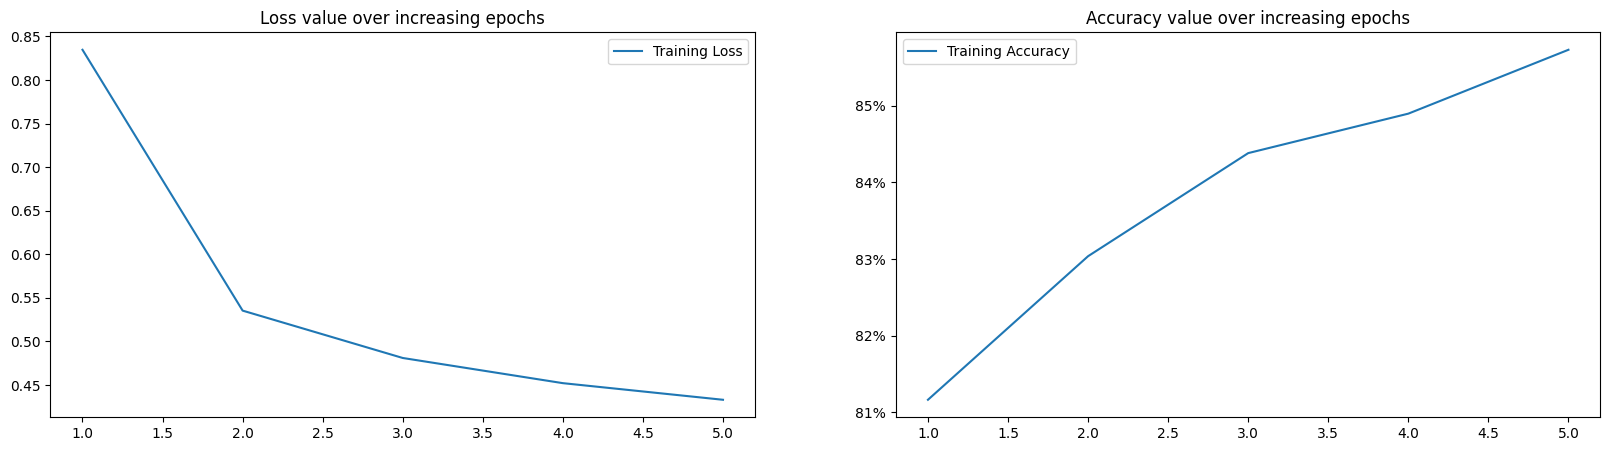

In [4]:
epochs = np.arange(5)+1
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()